The Standard Benchmark: Split CIFAR-10

This is the "Hello World" of modern continual learning.

The Split: The 10 classes of CIFAR-10 are divided into 5 discrete tasks.

Classes per Task: Each task introduces 2 new classes (e.g., Task 1: Airplane/Auto, Task 2: Bird/Cat, etc.).

The Goal: The model trains on Task 1, then Task 2, and so on. After training on Task 5, it is evaluated on the test sets of all 10 classes simultaneously.

Class-Incremental Learning (CIL)

Difficulty: Hard (Standard for modern research).

Setup: The model does not know which task an image belongs to at inference time. It must choose from all 10 possible classes (single-head evaluation).

Why choose this: This is the most realistic setting. If you are reading papers from 2021–2024, they likely use this.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# CIFAR-10 class names in order (indices 0-9)
CLASS_NAMES = [
    "airplane",
    "automobile", 
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# Split CIFAR-10 into 5 tasks, each with 2 classes
TASK_CLASSES = [
    [0, 1],  # Task 1: airplane, automobile
    [2, 3],  # Task 2: bird, cat
    [4, 5],  # Task 3: deer, dog
    [6, 7],  # Task 4: frog, horse
    [8, 9],  # Task 5: ship, truck
]

NUMBER_OF_TASKS = len(TASK_CLASSES)
CLASSES_PER_TASK = 2
TOTAL_CLASSES = 10

In [3]:
# Standard CIFAR-10 normalization
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD = (0.2470, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

# Load full CIFAR-10 dataset
full_train_dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=train_transform,
)

full_test_dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=test_transform,
)

100.0%
/Users/antonio/flair/software/personal-site/.venv/lib/python3.13/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [4]:
def get_indices_for_classes(dataset, class_list):
    """Return indices of samples belonging to specified classes."""
    indices = []
    for index, (_, label) in enumerate(dataset):
        if label in class_list:
            indices.append(index)
    return indices


def get_indices_for_classes_fast(dataset, class_list):
    """Return indices of samples belonging to specified classes (fast version)."""
    targets = torch.tensor(dataset.targets)
    mask = torch.zeros(len(targets), dtype=torch.bool)
    for class_index in class_list:
        mask |= (targets == class_index)
    return torch.where(mask)[0].tolist()

In [5]:
class SplitCIFAR10:
    """
    Split CIFAR-10 benchmark for class-incremental learning.
    
    - 5 tasks, each introducing 2 new classes
    - Training: sequential access to task-specific data
    - Evaluation: single-head classification over all 10 classes
    """
    
    def __init__(self, train_dataset, test_dataset, batch_size=128):
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size
        
        # Precompute indices for each task
        self.train_indices_per_task = []
        self.test_indices_per_task = []
        
        for task_index in range(NUMBER_OF_TASKS):
            class_list = TASK_CLASSES[task_index]
            
            train_indices = get_indices_for_classes_fast(train_dataset, class_list)
            test_indices = get_indices_for_classes_fast(test_dataset, class_list)
            
            self.train_indices_per_task.append(train_indices)
            self.test_indices_per_task.append(test_indices)
    
    def get_task_train_loader(self, task_index):
        """Get training data loader for a specific task."""
        indices = self.train_indices_per_task[task_index]
        subset = Subset(self.train_dataset, indices)
        return DataLoader(subset, batch_size=self.batch_size, shuffle=True)
    
    def get_task_test_loader(self, task_index):
        """Get test data loader for a specific task."""
        indices = self.test_indices_per_task[task_index]
        subset = Subset(self.test_dataset, indices)
        return DataLoader(subset, batch_size=self.batch_size, shuffle=False)
    
    def get_full_test_loader(self):
        """Get test data loader for all classes (for final evaluation)."""
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)
    
    def get_seen_classes_test_loader(self, up_to_task_index):
        """Get test data loader for all classes seen so far (tasks 0 to up_to_task_index)."""
        all_indices = []
        for task_index in range(up_to_task_index + 1):
            all_indices.extend(self.test_indices_per_task[task_index])
        subset = Subset(self.test_dataset, all_indices)
        return DataLoader(subset, batch_size=self.batch_size, shuffle=False)

In [6]:
# Create the benchmark
benchmark = SplitCIFAR10(full_train_dataset, full_test_dataset, batch_size=128)

# Print task structure
print("Split CIFAR-10 Benchmark")
print("=" * 40)
for task_index in range(NUMBER_OF_TASKS):
    class_indices = TASK_CLASSES[task_index]
    class_names = [CLASS_NAMES[i] for i in class_indices]
    train_count = len(benchmark.train_indices_per_task[task_index])
    test_count = len(benchmark.test_indices_per_task[task_index])
    print(f"Task {task_index + 1}: {class_names}")
    print(f"         Train samples: {train_count}, Test samples: {test_count}")

Split CIFAR-10 Benchmark
Task 1: ['airplane', 'automobile']
         Train samples: 10000, Test samples: 2000
Task 2: ['bird', 'cat']
         Train samples: 10000, Test samples: 2000
Task 3: ['deer', 'dog']
         Train samples: 10000, Test samples: 2000
Task 4: ['frog', 'horse']
         Train samples: 10000, Test samples: 2000
Task 5: ['ship', 'truck']
         Train samples: 10000, Test samples: 2000


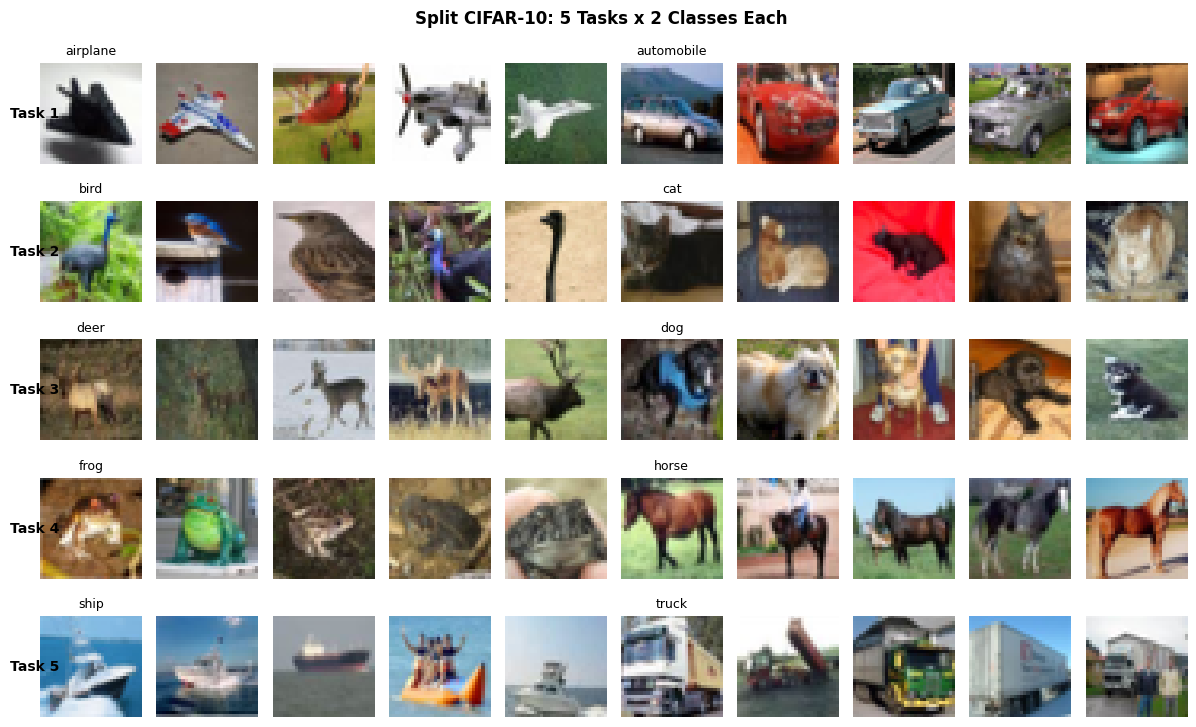

In [7]:
# Load raw dataset without normalization for visualization
raw_dataset = datasets.CIFAR10(
    root="./data",
    train=True,
    download=False,
    transform=transforms.ToTensor(),
)


def get_samples_for_class(dataset, class_index, number_of_samples=5):
    """Get sample images for a specific class."""
    samples = []
    for image, label in dataset:
        if label == class_index:
            samples.append(image)
            if len(samples) >= number_of_samples:
                break
    return samples


def visualize_task_structure(dataset, samples_per_class=5):
    """Visualize the Split CIFAR-10 task structure with sample images."""
    
    figure, axes = plt.subplots(
        nrows=NUMBER_OF_TASKS,
        ncols=samples_per_class * CLASSES_PER_TASK,
        figsize=(samples_per_class * CLASSES_PER_TASK * 1.2, NUMBER_OF_TASKS * 1.5),
    )
    
    for task_index in range(NUMBER_OF_TASKS):
        class_indices = TASK_CLASSES[task_index]
        
        column_offset = 0
        for class_index in class_indices:
            samples = get_samples_for_class(dataset, class_index, samples_per_class)
            
            for sample_index, image in enumerate(samples):
                axis = axes[task_index, column_offset + sample_index]
                
                # Convert tensor to numpy for display (C, H, W) -> (H, W, C)
                image_numpy = image.permute(1, 2, 0).numpy()
                axis.imshow(image_numpy)
                axis.axis("off")
                
                # Add class name label on first row of each class
                if sample_index == 0:
                    axis.set_title(CLASS_NAMES[class_index], fontsize=9)
            
            column_offset += samples_per_class
        
        # Add task label on the left
        axes[task_index, 0].annotate(
            f"Task {task_index + 1}",
            xy=(-0.3, 0.5),
            xycoords="axes fraction",
            fontsize=10,
            fontweight="bold",
            verticalalignment="center",
        )
    
    plt.suptitle("Split CIFAR-10: 5 Tasks x 2 Classes Each", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()


visualize_task_structure(raw_dataset, samples_per_class=5)

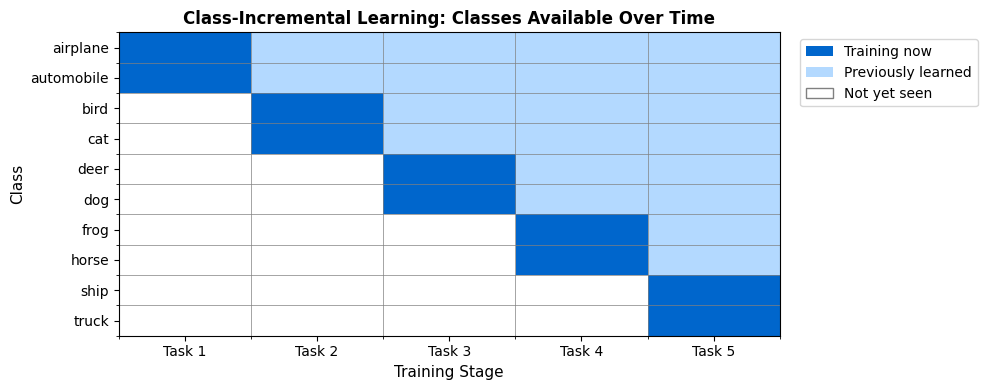

In [8]:
def visualize_learning_timeline():
    """Visualize which classes are available at each stage of training."""
    
    figure, axis = plt.subplots(figsize=(10, 4))
    
    # Create a matrix showing class availability over time
    # Rows = classes, Columns = tasks
    availability_matrix = np.zeros((TOTAL_CLASSES, NUMBER_OF_TASKS))
    
    for task_index in range(NUMBER_OF_TASKS):
        class_indices = TASK_CLASSES[task_index]
        for class_index in class_indices:
            # Mark class as available from this task onward (for training) 
            availability_matrix[class_index, task_index] = 2  # Currently training
            # Mark as "seen" for future tasks
            for future_task in range(task_index + 1, NUMBER_OF_TASKS):
                availability_matrix[class_index, future_task] = 1  # Previously seen
    
    # Custom colormap: white = not seen, light blue = previously seen, dark blue = currently training
    colors = ["#ffffff", "#b3d9ff", "#0066cc"]
    from matplotlib.colors import ListedColormap
    colormap = ListedColormap(colors)
    
    image = axis.imshow(availability_matrix, cmap=colormap, aspect="auto", vmin=0, vmax=2)
    
    # Labels
    axis.set_xticks(range(NUMBER_OF_TASKS))
    axis.set_xticklabels([f"Task {i+1}" for i in range(NUMBER_OF_TASKS)])
    axis.set_yticks(range(TOTAL_CLASSES))
    axis.set_yticklabels(CLASS_NAMES)
    
    axis.set_xlabel("Training Stage", fontsize=11)
    axis.set_ylabel("Class", fontsize=11)
    axis.set_title("Class-Incremental Learning: Classes Available Over Time", fontsize=12, fontweight="bold")
    
    # Add grid
    axis.set_xticks(np.arange(-0.5, NUMBER_OF_TASKS, 1), minor=True)
    axis.set_yticks(np.arange(-0.5, TOTAL_CLASSES, 1), minor=True)
    axis.grid(which="minor", color="gray", linestyle="-", linewidth=0.5)
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor="#0066cc", label="Training now"),
        Patch(facecolor="#b3d9ff", label="Previously learned"),
        Patch(facecolor="#ffffff", edgecolor="gray", label="Not yet seen"),
    ]
    axis.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1.02, 1))
    
    plt.tight_layout()
    plt.show()


visualize_learning_timeline()

In [ ]:
assert False

In [ ]:
class SimpleConvNet(nn.Module):
    """A simple convolutional network for CIFAR-10."""
    
    def __init__(self, number_of_classes=TOTAL_CLASSES):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, number_of_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
def train_one_epoch(model, data_loader, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * len(labels)
        predictions = outputs.argmax(dim=1)
        total_correct += (predictions == labels).sum().item()
        total_samples += len(labels)
    
    average_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return average_loss, accuracy


def evaluate(model, data_loader, device):
    """Evaluate the model on a data loader."""
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            predictions = outputs.argmax(dim=1)
            total_correct += (predictions == labels).sum().item()
            total_samples += len(labels)
    
    accuracy = total_correct / total_samples
    return accuracy

In [ ]:
def run_continual_learning(benchmark, epochs_per_task=5, learning_rate=0.001):
    """
    Run the continual learning experiment.
    
    This is the naive baseline (fine-tuning) which will exhibit catastrophic forgetting.
    """
    model = SimpleConvNet(number_of_classes=TOTAL_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Store accuracy on each task's test set after each task is learned
    accuracy_matrix = []  # accuracy_matrix[i][j] = accuracy on task j after learning task i
    
    for task_index in range(NUMBER_OF_TASKS):
        task_classes = [CLASS_NAMES[i] for i in TASK_CLASSES[task_index]]
        print(f"\n{'='*50}")
        print(f"Training on Task {task_index + 1}: {task_classes}")
        print(f"{'='*50}")
        
        train_loader = benchmark.get_task_train_loader(task_index)
        
        # Train on current task
        for epoch in range(epochs_per_task):
            loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, DEVICE)
            print(f"  Epoch {epoch + 1}/{epochs_per_task} - Loss: {loss:.4f}, Train Acc: {train_accuracy:.2%}")
        
        # Evaluate on all tasks seen so far
        print(f"\nEvaluation after Task {task_index + 1}:")
        task_accuracies = []
        for eval_task_index in range(NUMBER_OF_TASKS):
            test_loader = benchmark.get_task_test_loader(eval_task_index)
            accuracy = evaluate(model, test_loader, DEVICE)
            task_accuracies.append(accuracy)
            
            if eval_task_index <= task_index:
                status = "SEEN"
            else:
                status = "NOT YET SEEN"
            print(f"  Task {eval_task_index + 1} ({status}): {accuracy:.2%}")
        
        accuracy_matrix.append(task_accuracies)
        
        # Evaluate on all classes seen so far (class-incremental evaluation)
        seen_test_loader = benchmark.get_seen_classes_test_loader(task_index)
        overall_accuracy = evaluate(model, seen_test_loader, DEVICE)
        print(f"\n  Overall accuracy on seen classes: {overall_accuracy:.2%}")
    
    return model, accuracy_matrix

In [ ]:
# Run the experiment
model, accuracy_matrix = run_continual_learning(benchmark, epochs_per_task=5)

In [ ]:
def compute_metrics(accuracy_matrix):
    """
    Compute standard continual learning metrics.
    
    - Final accuracy: accuracy on all tasks after training on all tasks
    - Forgetting: how much performance dropped on earlier tasks
    """
    accuracy_matrix = torch.tensor(accuracy_matrix)
    number_of_tasks = len(accuracy_matrix)
    
    # Final average accuracy (after all tasks)
    final_accuracies = accuracy_matrix[-1]  # Accuracies on all tasks after final task
    final_average_accuracy = final_accuracies.mean().item()
    
    # Average forgetting: for each task, how much did accuracy drop from peak?
    forgetting_per_task = []
    for task_index in range(number_of_tasks - 1):  # Exclude last task (no forgetting possible)
        # Peak accuracy on this task (achieved right after learning it)
        peak_accuracy = accuracy_matrix[task_index, task_index].item()
        # Final accuracy on this task
        final_accuracy = accuracy_matrix[-1, task_index].item()
        forgetting = peak_accuracy - final_accuracy
        forgetting_per_task.append(forgetting)
    
    average_forgetting = sum(forgetting_per_task) / len(forgetting_per_task) if forgetting_per_task else 0
    
    return {
        "final_average_accuracy": final_average_accuracy,
        "average_forgetting": average_forgetting,
        "forgetting_per_task": forgetting_per_task,
    }


metrics = compute_metrics(accuracy_matrix)

print("\n" + "="*50)
print("FINAL METRICS")
print("="*50)
print(f"Final Average Accuracy: {metrics['final_average_accuracy']:.2%}")
print(f"Average Forgetting: {metrics['average_forgetting']:.2%}")
print("\nForgetting per task:")
for task_index, forgetting in enumerate(metrics['forgetting_per_task']):
    task_classes = [CLASS_NAMES[i] for i in TASK_CLASSES[task_index]]
    print(f"  Task {task_index + 1} ({task_classes}): {forgetting:.2%}")